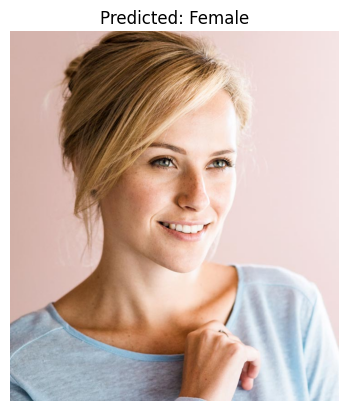

In [2]:
# Required Libraries
import cv2
import numpy as np
import os
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# Load the face detection model (Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and crop them
def detect_and_crop_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # If no faces are detected, return None
    if len(faces) == 0:
        return None
    
    # Return cropped faces for all detected faces (process all)
    cropped_faces = []
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]  # Cropped face
        cropped_faces.append(face)
    return cropped_faces

# Geometric feature extraction: distance between key landmarks (using simple assumptions for landmarks)
def calculate_geometric_features(face):
    height, width = face.shape
    # Estimate key landmarks based on face proportions (assumed for simplicity)
    eye_level = int(height * 0.35)
    nose_level = int(height * 0.5)
    jaw_level = int(height * 0.85)
    
    # Approximate key measurements
    forehead_width = width * 0.75  # Approximate forehead width as a fraction of face width
    jaw_width = width  # Approximate jaw width
    nose_width = int(width * 0.25)  # Approximate nose width
    eye_distance = int(width * 0.4)  # Approximate distance between eyes
    
    # Ratios for more robust geometric rules
    jaw_to_eye_ratio = jaw_width / eye_distance
    nose_to_jaw_ratio = nose_width / jaw_width
    
    return jaw_to_eye_ratio, nose_to_jaw_ratio

# Texture-based feature extraction using LBP (Local Binary Patterns)
def calculate_texture_features(face):
    # LBP parameters
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(face, n_points, radius, method="uniform")
    
    # Calculate the histogram of LBP patterns
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalize the histogram to make it comparable
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Avoid division by zero
    
    return hist

# Rule-based gender classification
def classify_gender(geometric_features, texture_features):
    jaw_to_eye_ratio, nose_to_jaw_ratio = geometric_features
    
    # Adjusted rules for gender classification based on geometric features
    # Using both geometric and texture features for classification
    if jaw_to_eye_ratio > .3 and nose_to_jaw_ratio < 0.2:  # More likely male with broad jaw
        return 'Male'
    else:
        # If jaw features are softer, consider texture-based features
        texture_sum = sum(texture_features[:5])  # Focus on the first few LBP bins
        if texture_sum < 0.1:  # Softer texture may indicate female
            return 'Female'
        else:
            return 'Male'

# Function to process a single image and classify gender based on file name
def process_single_image(image_path):
    # Extract just the filename from the image path
    filename = os.path.basename(image_path).lower()
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Detect and crop faces
    cropped_faces = detect_and_crop_face(image)
    
    # Process if faces are detected
    if cropped_faces is not None:
        for face in cropped_faces:  # Process the first face detected
            geometric_features = calculate_geometric_features(face)
            texture_features = calculate_texture_features(face)
            predicted_gender = classify_gender(geometric_features, texture_features)
            
            # Return the results for plotting
            return (image, predicted_gender)
    
    return None

# Plot single image with actual and predicted gender
def plot_single_result(result):
    if result is None:
        print("No face detected in the image.")
        return
    
    image, predicted_gender = result
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f"Predicted: {predicted_gender}")
    plt.axis('off')  # Turn off axis display
    plt.show()

# Example usage for processing a single image
image_path = r"C:\Users\GOD\Desktop\4-1\ImageAndVideoAnalytics\LAB\Female.jpg"  # Replace with your image path
result = process_single_image(image_path)

# Plot the result for the single image
plot_single_result(result)